# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6909, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6909 entries, 0 to 6908
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6909 non-null   int64  
 1   year                 6909 non-null   int64  
 2   productGrouping      6909 non-null   object 
 3   totalSpent           6909 non-null   float64
 4   recentDate           6909 non-null   object 
 5   attendancePercent    6909 non-null   float64
 6   renewedBeforeDays    6909 non-null   int64  
 7   source_tenure        6909 non-null   int64  
 8   tenure               6909 non-null   int64  
 9   distToVenue          6670 non-null   float64
 10  recency              6909 non-null   int64  
 11  missed_games_1       6909 non-null   int64  
 12  missed_games_2       6909 non-null   int64  
 13  missed_games_over_2  6909 non-null   int64  
 14  isNextYear_Buyer     6909 non-null   int64  
dtypes: float64(3), int64(10), object(2)
me

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3596, 15)
Unseen Data For Predictions: (634, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","lr","xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6253,0.6727,0.6997,0.6000,0.6457,0.2531,0.2568,0.2580
lightgbm,Light Gradient Boosting Machine,0.6201,0.6841,0.6595,0.6015,0.6287,0.2414,0.2429,1.0290
xgboost,Extreme Gradient Boosting,0.6178,0.6833,0.6422,0.6019,0.6209,0.2364,0.2373,0.3110


In [8]:
lightgbm_model = create_model('lightgbm')
lr_model = create_model('lr')
xgboost_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5915,0.6489,0.6067,0.5796,0.5928,0.1834,0.1836
1,0.6078,0.6762,0.5867,0.6027,0.5946,0.2150,0.2151
2,0.5817,0.6604,0.5973,0.5669,0.5817,0.1640,0.1642
3,0.6144,0.6866,0.6443,0.5963,0.6194,0.2298,0.2305
4,0.6503,0.7091,0.6644,0.6346,0.6492,0.3010,0.3013
5,0.6503,0.7079,0.7047,0.6250,0.6625,0.3024,0.3048
6,0.6164,0.6773,0.6980,0.5909,0.6400,0.2355,0.2392
7,0.5803,0.6576,0.6174,0.5644,0.5897,0.1620,0.1627
8,0.6721,0.7239,0.6980,0.6541,0.6753,0.3449,0.3456
9,0.6131,0.6853,0.6040,0.6040,0.6040,0.2258,0.2258


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2679, 15)

In [10]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)
lr_predictions = predict_model(lr_model, data=df_inference, raw_score=True)
xgboost_predictions = predict_model(xgboost_model, data=df_inference, raw_score=True)

In [17]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")
print(f"log reg:\n {lr_predictions.Label.value_counts()}")
print(f"xgboost:\n {xgboost_predictions.Label.value_counts()}")

lightgbm:
 0    2229
1     450
Name: Label, dtype: int64
log reg:
 0    2116
1     563
Name: Label, dtype: int64
xgboost:
 0    1851
1     828
Name: Label, dtype: int64


In [44]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"lr:\n {lr_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"xgboost:\n {xgboost_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    1406
(0.25, 0.5]        823
(0.5, 0.75]        398
(0.75, 1.0]         52
Name: Score_1, dtype: int64
lr:
 (0.25, 0.5]       1958
(0.5, 0.75]        540
(-0.001, 0.25]     158
(0.75, 1.0]         23
Name: Score_1, dtype: int64
xgboost:
 (-0.001, 0.25]    1357
(0.25, 0.5]        494
(0.5, 0.75]        456
(0.75, 1.0]        372
Name: Score_1, dtype: int64


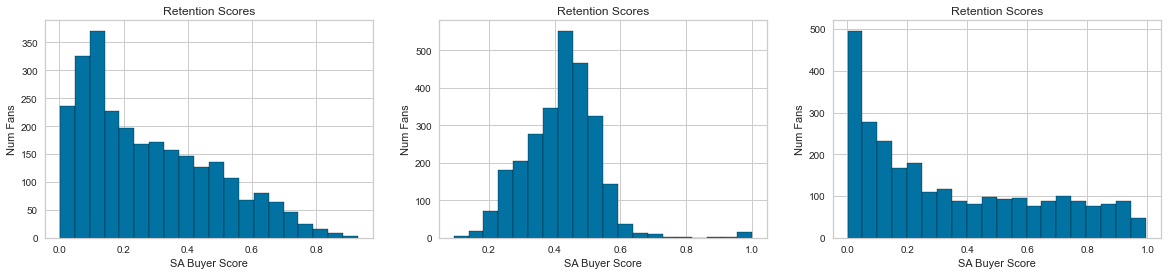

In [37]:
model_predictions = [lightgbm_predictions, lr_predictions, xgboost_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

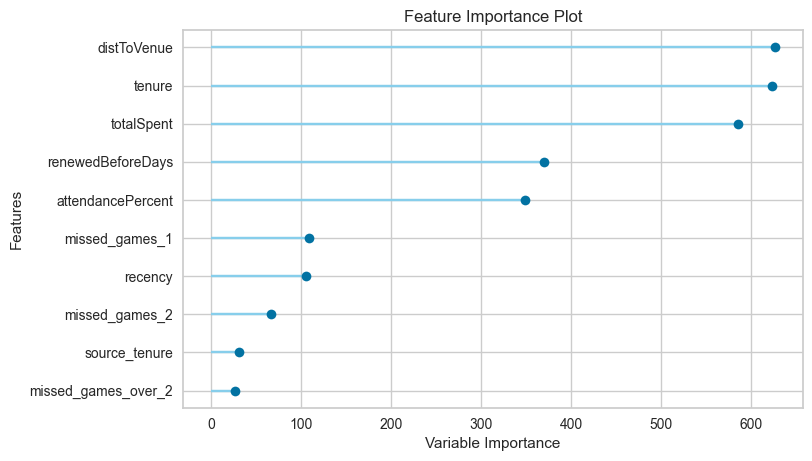

In [40]:
plot_model(lightgbm_model, plot='feature')

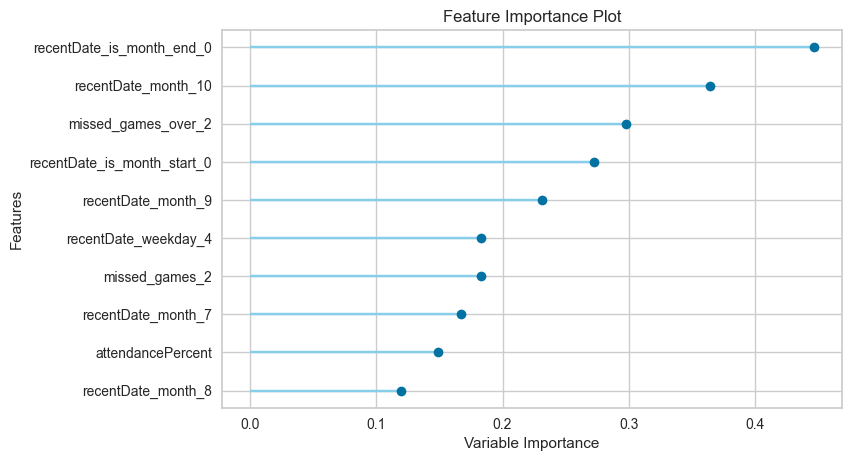

In [41]:
plot_model(lr_model, plot='feature')

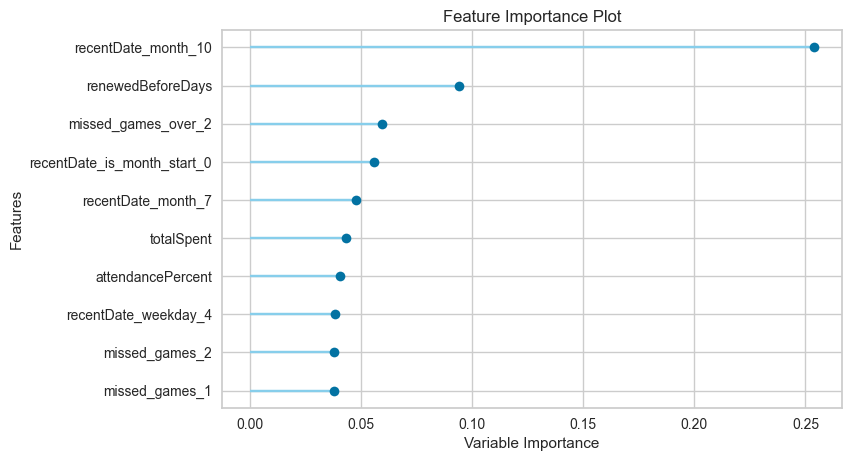

In [42]:
plot_model(xgboost_model, plot='feature')

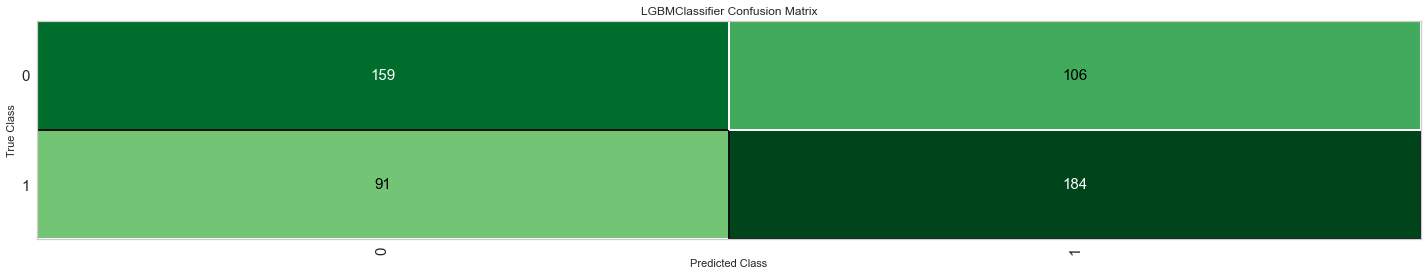

In [45]:
plot_model(lightgbm_model, plot='confusion_matrix')

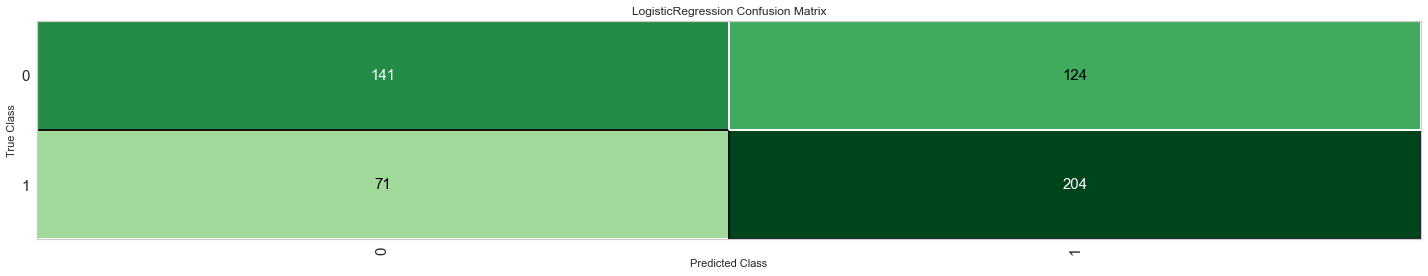

In [46]:
plot_model(lr_model, plot='confusion_matrix')

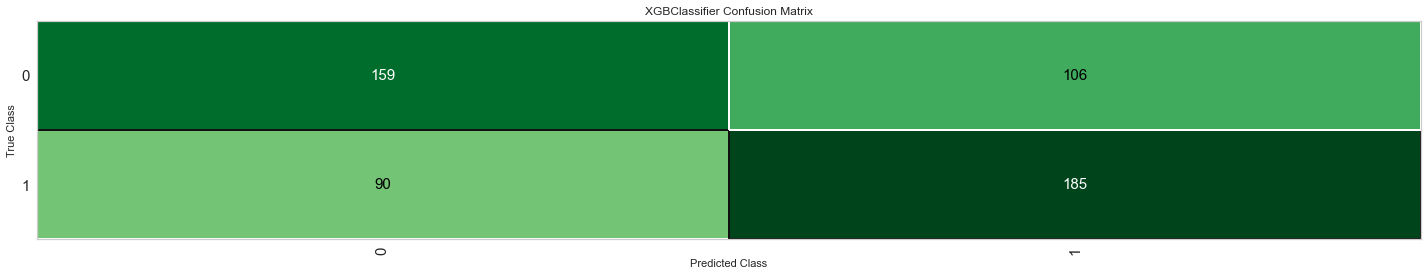

In [47]:
plot_model(xgboost_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above